In [18]:
%run deps.py
%matplotlib inline

In [15]:
protvec_model = biovec.models.load_protvec('./trained_models/swissprot_reviewed_protvec')

if os.path.exists("protein_model.pkl"):
    # If model was already trained then just load it.
    w2v_proteins = gensim.models.Word2Vec.load("protein_model.pkl")
else:
    # Else let's train and save it for later reuse
    w2v_proteins = train_seq2vec("uniprot-human.fasta")
    w2v_proteins.save("protein_model.pkl")
    
def seq2protvec_(seq):
    return sum(protvec_model.to_vecs(seq))


def get_labels(labels_col):
    le = LabelEncoder()
    return le.fit_transform(labels_col)

def get_protvec(data):
    seq2pv = data.apply(seq2protvec)
    seq2pv = list(seq2pv)
    return seq2pv

def get_w2vecs(seq):
    w2vecs = seq.apply(partial(seq2vec, w2v_proteins))
    w2vecs = list(w2vecs)
    return w2vecs

def meas2binary(meases):
    return pd.Series(map(lambda x: 1 if x >= log_meas(500) else 0, meases))

def xgb_regression(data, target):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=442)
    
    xgbr = xgb.XGBRegressor(max_depth=9, learning_rate=0.1, n_estimators=750, gamma=0, min_child_weight=5,
                            reg_lambda = 0.3, subsample=0.9, colsample_bytree = 0.9, nthread=15, silent=False)
    
    xgbr.fit(X_train, y_train)
    
    preds = xgbr.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    f1 = f1_score(meas2binary(y_test), meas2binary(preds))
    print("RMSE on test: {0:.4f}".format(mse))
    print("F1-score on test:{}".format(f1))
    return mse, f1

def get_rmse_of_models(performance, my_performance_mse, my_performance_f1, alleles):
    
    """
    arguments:
    
    performance - 
    alleles - list of alleles names
    my_performnace - 
    
    --------
    function get_rmse_of_models extract dataset of specific allele from performance dataset, calculates rmse on 
    each allele and stores it in dicts
    --------
    returns: 3 tuples
    
    netmhc_rmse - tuple of rmse of netmhc on every alelle
    netmhcpan_rmse - tuple of rmse of netmhcpan on every alelle
    pmbec_rmse - tuple of rmse of smm_pmbec on every alelle
    
    """
    
    netmhc_rmse = {}
    netmhcpan_rmse = {}
    pmbec_rmse = {}
    mhc_rmse = {}
    
    netmhc_f1 = {}
    netmhcpan_f1 = {}
    pmbec_f1 = {}
    mhc_f1 = {}
    
    for index, cur_al in enumerate(alleles):
        
        cur_alelle = select_by_allele(performance, cur_al)
        print("\n#{:d} {}:".format(index, cur_al))
        print("Shapes: ", cur_alelle.shape, cur_alelle.meas.shape)
        if(len(cur_alelle) == 0):
            continue
        netmhc_rmse[cur_al] = mean_squared_error(cur_alelle.meas, cur_alelle.netmhc)
        netmhcpan_rmse[cur_al] = mean_squared_error(cur_alelle.meas, cur_alelle.netmhcpan)
        pmbec_rmse[cur_al] = mean_squared_error(cur_alelle.meas, cur_alelle.smmpmbec_cpp)
        
        netmhc_f1[cur_al] = f1_score(meas2binary(cur_alelle.meas), meas2binary(cur_alelle.netmhc))
        netmhcpan_f1[cur_al] = f1_score(meas2binary(cur_alelle.meas), meas2binary(cur_alelle.netmhcpan))
        pmbec_f1[cur_al] = f1_score(meas2binary(cur_alelle.meas), meas2binary(cur_alelle.smmpmbec_cpp))
        
    
    netmhc_df = pd.DataFrame.from_dict(netmhc_rmse, orient='index')
    netmhcpan_df = pd.DataFrame.from_dict(netmhcpan_rmse, orient='index')
    pmbec_df = pd.DataFrame.from_dict(pmbec_rmse, orient='index')
    xgb_df = pd.DataFrame.from_dict(my_performance_mse, orient='index')

    models_perf_mse = pd.concat([xgb_df, netmhc_df, netmhcpan_df, pmbec_df], axis=1)
    models_perf_mse.columns=["mhystic", "netmhc", "netmhcpan", "pmbec"]
    
    netmhc_df = pd.DataFrame.from_dict(netmhc_f1, orient='index')
    netmhcpan_df = pd.DataFrame.from_dict(netmhcpan_rmse, orient='index')
    pmbec_df = pd.DataFrame.from_dict(pmbec_f1, orient='index')
    xgb_df = pd.DataFrame.from_dict(my_performance_f1, orient='index')

    models_perf_f1 = pd.concat([xgb_df, netmhc_df, netmhcpan_df, pmbec_df], axis=1)
    models_perf_f1.columns=["mhystic", "netmhc", "netmhcpan", "pmbec"]
    
    return models_perf_mse, models_perf_f1


def evaluate_pv_by_allele(dataset, alleles):
    
    """
    arguments:
    
    alleles - list of alleles names
    --------
    function evaluate_by_allele extract dataset of specific allele from Bdata in which there are sequence and affinity 
    using select_by_allele function, saves it in csv, then constructing word2vec representation of this 
    sequences and evaluates xgb model, which return rmse on this allele.
    --------
    returns: 
    
    mhc_rmse tuple of rmse on every allele in alleles
    """
    
    mhc_rmse = {}
    mhc_f1 = {}
    
    for index,cur_al in enumerate(alleles):
        
        current_allele = select_by_allele(dataset, cur_al)
        
        if(len(current_allele) == 1):
            continue
            
        cur_al_affinity = current_allele.meas
        
        #pv_protein = get_protvec(current_allele.protein)
        pv_peptide = get_protvec(current_allele.sequence)
        
        #pv_mean = np.array([i/2 for i in np.add(pv_protein, pv_peptide)])
        #pv_res = np.subtract(pv_protein, pv_peptide)
        #pv_sum = np.add(pv_protein, pv_peptide)
        
        
        print("\n#{:d} {}:".format(index, cur_al))
        print("Shapes: ", current_allele.shape, cur_al_affinity.shape)
        
        allele_rmse, allele_f1 = xgb_regression(pv_peptide, cur_al_affinity)
        mhc_rmse[cur_al] = allele_rmse
        mhc_f1[cur_al] = allele_f1
    
    return mhc_rmse, mhc_f1

def evaluate_w2v_by_allele(dataset, alleles):
    
    """
    arguments:
    
    alleles - list of alleles names
    --------
    function evaluate_by_allele extract dataset of specific allele from Bdata in which there are sequence and affinity 
    using select_by_allele function, saves it in csv, then constructing word2vec representation of this 
    sequences and evaluates xgb model, which return rmse on this allele.
    --------
    returns: 
    
    mhc_rmse tuple of rmse on every allele in alleles
    """
    
    mhc_rmse = {}
    mhc_f1 = {}
    
    for index,cur_al in enumerate(alleles):
        
        current_allele = select_by_allele(dataset, cur_al)
        
        if(len(current_allele) == 1):
            continue
            
        cur_al_affinity = current_allele.meas
        
        #pv_protein = get_protvec(current_allele.protein)
        pv_peptide = get_w2vecs(current_allele.sequence)
        
        #pv_mean = np.array([i/2 for i in np.add(pv_protein, pv_peptide)])
        #pv_res = np.subtract(pv_protein, pv_peptide)
        #pv_sum = np.add(pv_protein, pv_peptide)
        
        
        print("\n#{:d} {}:".format(index, cur_al))
        print("Shapes: ", current_allele.shape, cur_al_affinity.shape)
        
        allele_rmse, allele_f1 = xgb_regression(pv_peptide, cur_al_affinity)
        mhc_rmse[cur_al] = allele_rmse
        mhc_f1[cur_al] = allele_f1
    
    return mhc_rmse, mhc_f1

def plot_results(results, description):
    
    """
    results - DataFrame with columns "mhystic", "netmhc", "netmhcpan", "pmbec"
    
    """
    
    allele_rmse_figure = plt.figure(figsize=(48, 27))
    plt.title("RMSE.{}".format(description))
    plt.xlabel("$RMSE$")
    plt.ylabel("Alleles")

    ind = np.arange(0, 4*len(list(results.index)), 4) 
    width = 0.6
    ys = plt.yticks(ind, list(results.index), rotation=0)
    plt.locator_params(nbins=len(results.mhystic))

    xgb_rects = plt.barh(ind, list(results.mhystic), width, align='center', color='red', alpha=0.3, label = 'MHystic', edgecolor='w')
    plt.barh(ind + width , list(results.netmhc), width, align='center', color='yellow', alpha=0.3, label='netmhc')
    plt.barh(ind + 2*width, list(results.netmhcpan), width, align='center', color='blue', alpha=0.3, label='netmhcpan')
    plt.barh(ind + 3*width, list(results.pmbec), width, align='center', color='black', alpha=0.3, label='pmbec')

    plt.legend(fontsize='xx-large')


    rounded_rmse_xgb = ["{0:.5f}".format(i) for i in list(results.mhystic)]

    for cur_rect, value in zip(xgb_rects.patches, rounded_rmse_xgb):
        plt.text(cur_rect.get_width() +0.001, cur_rect.get_y() - 0.5, value, ha='center', va='bottom', fontsize=15)

    
    allele_rmse_figure.savefig('rmse {}.png'.format(description), dpi=allele_rmse_figure.dpi)

INFO : loading Word2Vec object from ./trained_models/swissprot_reviewed_protvec
INFO : setting ignored attribute syn0norm to None
INFO : setting ignored attribute cum_table to None
INFO : loaded ./trained_models/swissprot_reviewed_protvec
INFO : loading Word2Vec object from protein_model.pkl
INFO : setting ignored attribute syn0norm to None
INFO : setting ignored attribute cum_table to None
INFO : loaded protein_model.pkl


In [8]:
Bdata = pd.read_csv("./data/bdata.csv")
Bdata.meas = [log_meas(i) for i in Bdata.meas]
data9mers = Bdata[Bdata.peptide_length == 9].reset_index()

hla_abce = select_hla(data9mers)
seq_dict = pd.read_csv("./data/mhc_seq_imghtla.csv")
common = set(seq_dict.mhc).intersection(set(hla_abce.mhc))
seq_dict = seq_dict[seq_dict["mhc"].isin(common)].reset_index(drop=True)
hla_abce = hla_abce.iloc[np.array(np.where(hla_abce.mhc.apply(lambda x:x in common))).flatten()].reset_index(drop=True)
hla_abce["protein"] = [seq_dict.loc[seq_dict.mhc==i].sequence.values[0] for i in hla_abce.mhc]

In [ ]:
"""proteins2pv = get_protvec(hla_abce.protein)
peptides2pv = get_protvec(hla_abce.sequence)
pv_res = np.subtract(proteins2pv, peptides2pv)
pv_div = np.divide(proteins2pv, peptides2pv)
pv_sum = np.add(proteins2pv, peptides2pv)
pv_mean = np.array([i/2 for i in pv_sum])"""

In [10]:
performance_data = pd.read_csv("./data/model_performance_logged.csv").drop("Unnamed: 0", axis=1)
performance_data.tail()

unify_alleles = lambda x: re.sub('[-|*]', '', x)

performance_data.mhc = performance_data.mhc.apply(unify_alleles)

common_alleles = list(set(hla_abce.mhc).intersection(performance_data.mhc))

errors = evaluate_w2v_by_allele(hla_abce, common_alleles)
errors_rmse = OrderedDict(sorted(errors[0].items(), key=lambda t: t[0]))
errors_f1 = OrderedDict(sorted(errors[1].items(), key=lambda t: t[0]))
performance_df_mse, performance_df_f1 = get_rmse_of_models(performance_data, errors[0], errors[1], common_alleles)


#0 HLAA0101:
Shapes:  (3680, 8) (3680,)
RMSE on test: 0.0174
F1-score on test:0.7164179104477613

#1 HLAA2601:
Shapes:  (3559, 8) (3559,)
RMSE on test: 0.0173
F1-score on test:0.6341463414634146

#2 HLAA3001:
Shapes:  (2426, 8) (2426,)
RMSE on test: 0.0333
F1-score on test:0.7902097902097902

#3 HLAB5401:
Shapes:  (721, 8) (721,)
RMSE on test: 0.0271
F1-score on test:0.7083333333333334

#4 HLAA0203:
Shapes:  (4427, 8) (4427,)
RMSE on test: 0.0328
F1-score on test:0.8092307692307692

#5 HLAA0201:
Shapes:  (8826, 8) (8826,)
RMSE on test: 0.0280
F1-score on test:0.8447204968944099

#6 HLAB0702:
Shapes:  (3619, 8) (3619,)
RMSE on test: 0.0251
F1-score on test:0.7929292929292928

#7 HLAA6801:
Shapes:  (2036, 8) (2036,)
RMSE on test: 0.0338
F1-score on test:0.7953216374269007

#8 HLAA2501:
Shapes:  (935, 8) (935,)
RMSE on test: 0.0118
F1-score on test:0.625

#9 HLAB1517:
Shapes:  (1430, 8) (1430,)
RMSE on test: 0.0335
F1-score on test:0.8148148148148148

#10 HLAA2902:
Shapes:  (1982, 8) (19

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


RMSE on test: 0.0061
F1-score on test:0.0

#16 HLAA3101:
Shapes:  (3860, 8) (3860,)
RMSE on test: 0.0276
F1-score on test:0.7352941176470588

#17 HLAA6901:
Shapes:  (2557, 8) (2557,)
RMSE on test: 0.0217
F1-score on test:0.5581395348837209

#18 HLAA0301:
Shapes:  (5231, 8) (5231,)
RMSE on test: 0.0225
F1-score on test:0.778225806451613

#19 HLAA0206:
Shapes:  (3732, 8) (3732,)
RMSE on test: 0.0432
F1-score on test:0.7863777089783281

#20 HLAB4501:
Shapes:  (574, 8) (574,)
RMSE on test: 0.0164
F1-score on test:0.7567567567567567

#21 HLAB0802:
Shapes:  (998, 8) (998,)
RMSE on test: 0.0057
F1-score on test:0.4444444444444445

#22 HLAB1501:
Shapes:  (3797, 8) (3797,)
RMSE on test: 0.0330
F1-score on test:0.7061855670103093

#23 HLAB3801:
Shapes:  (491, 8) (491,)
RMSE on test: 0.0229
F1-score on test:0.8918918918918919

#24 HLAB1509:
Shapes:  (814, 8) (814,)
RMSE on test: 0.0144
F1-score on test:0.4

#25 HLAB5301:
Shapes:  (937, 8) (937,)
RMSE on test: 0.0381
F1-score on test:0.76388888888

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



#14 HLAA6802:
Shapes:  (457, 4) (457,)

#15 HLAB0803:
Shapes:  (234, 4) (234,)

#16 HLAA3101:
Shapes:  (521, 4) (521,)

#17 HLAA6901:
Shapes:  (470, 4) (470,)

#18 HLAA0301:
Shapes:  (591, 4) (591,)

#19 HLAA0206:
Shapes:  (482, 4) (482,)

#20 HLAB4501:
Shapes:  (65, 4) (65,)

#21 HLAB0802:
Shapes:  (509, 4) (509,)

#22 HLAB1501:
Shapes:  (633, 4) (633,)

#23 HLAB3801:
Shapes:  (351, 4) (351,)

#24 HLAB1509:
Shapes:  (466, 4) (466,)

#25 HLAB5301:
Shapes:  (296, 4) (296,)

#26 HLAA2301:
Shapes:  (242, 4) (242,)

#27 HLAA0202:
Shapes:  (126, 4) (126,)

#28 HLAA2402:
Shapes:  (346, 4) (346,)

#29 HLAB1801:
Shapes:  (503, 4) (503,)

#30 HLAA3002:
Shapes:  (267, 4) (267,)

#31 HLAB4403:
Shapes:  (205, 4) (205,)

#32 HLAA2603:
Shapes:  (312, 4) (312,)

#33 HLAB5101:
Shapes:  (673, 4) (673,)

#34 HLAA8001:
Shapes:  (379, 4) (379,)

#35 HLAB2705:
Shapes:  (249, 4) (249,)

#36 HLAB3501:
Shapes:  (341, 4) (341,)

#37 HLAA3201:
Shapes:  (256, 4) (256,)

#38 HLAB5801:
Shapes:  (275, 4) (275,)

#

/root/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


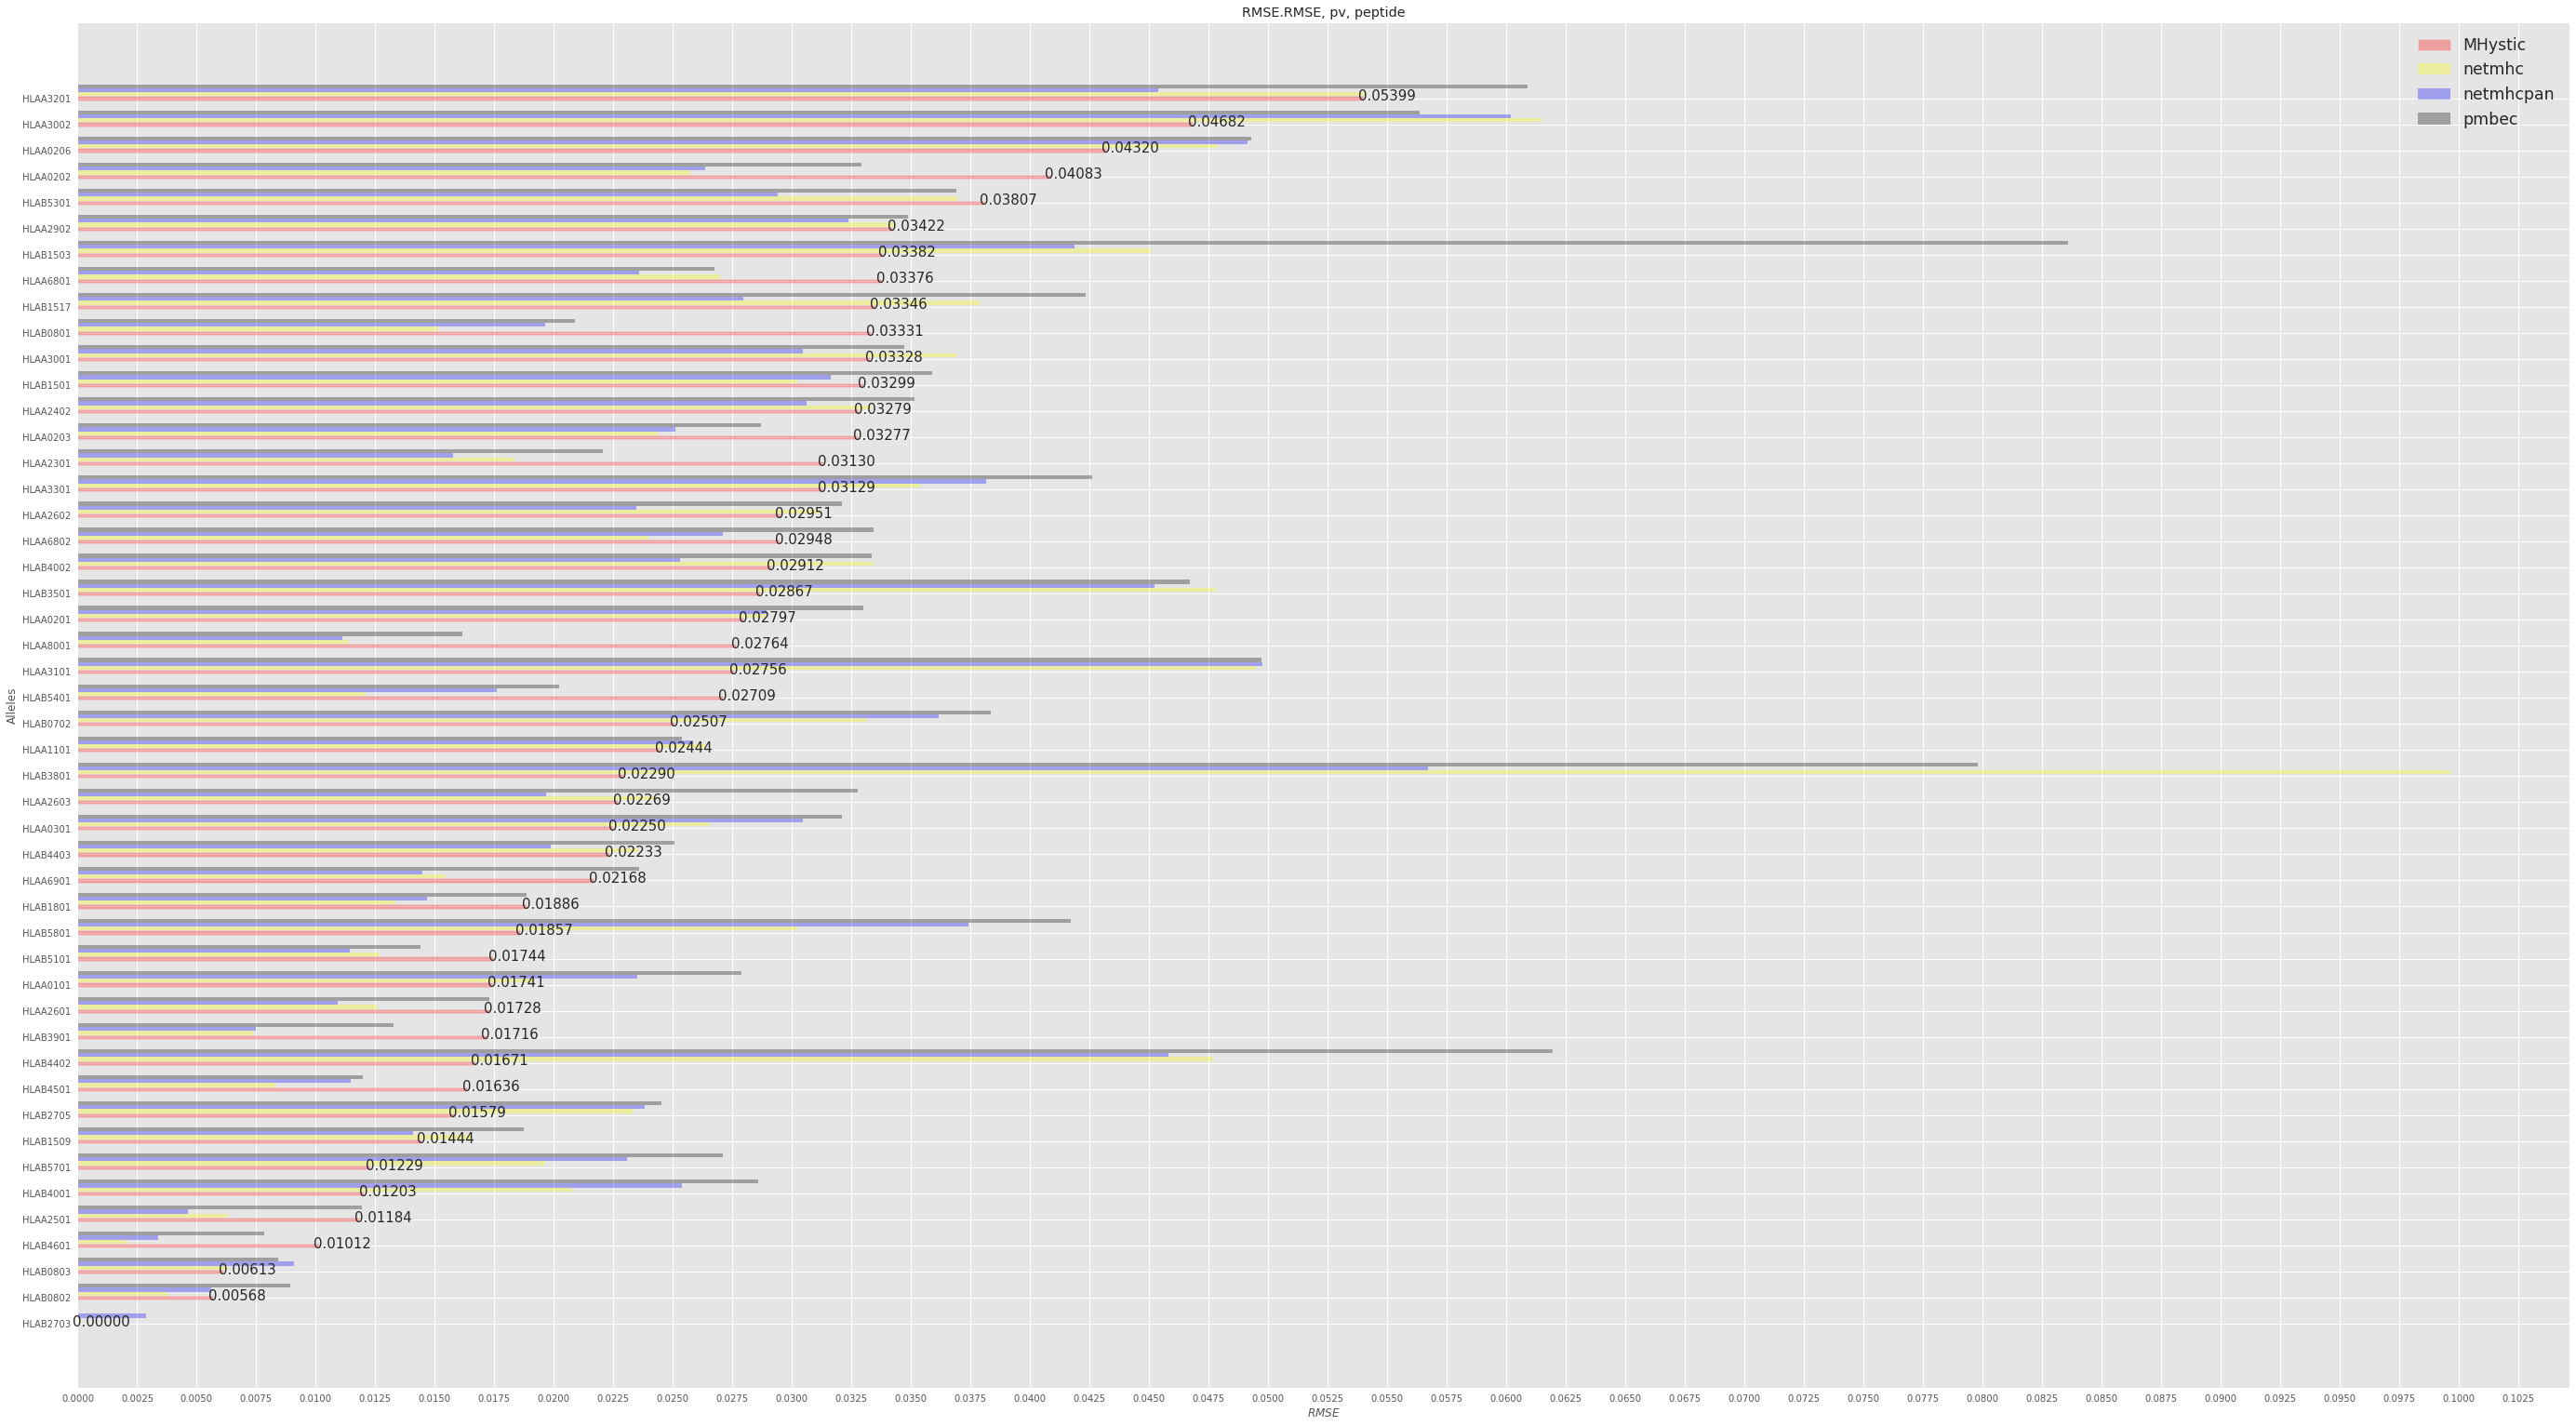

In [11]:
plot_results(performance_df_mse.sort('mhystic', ascending=True), "RMSE, pv, peptide")

/root/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


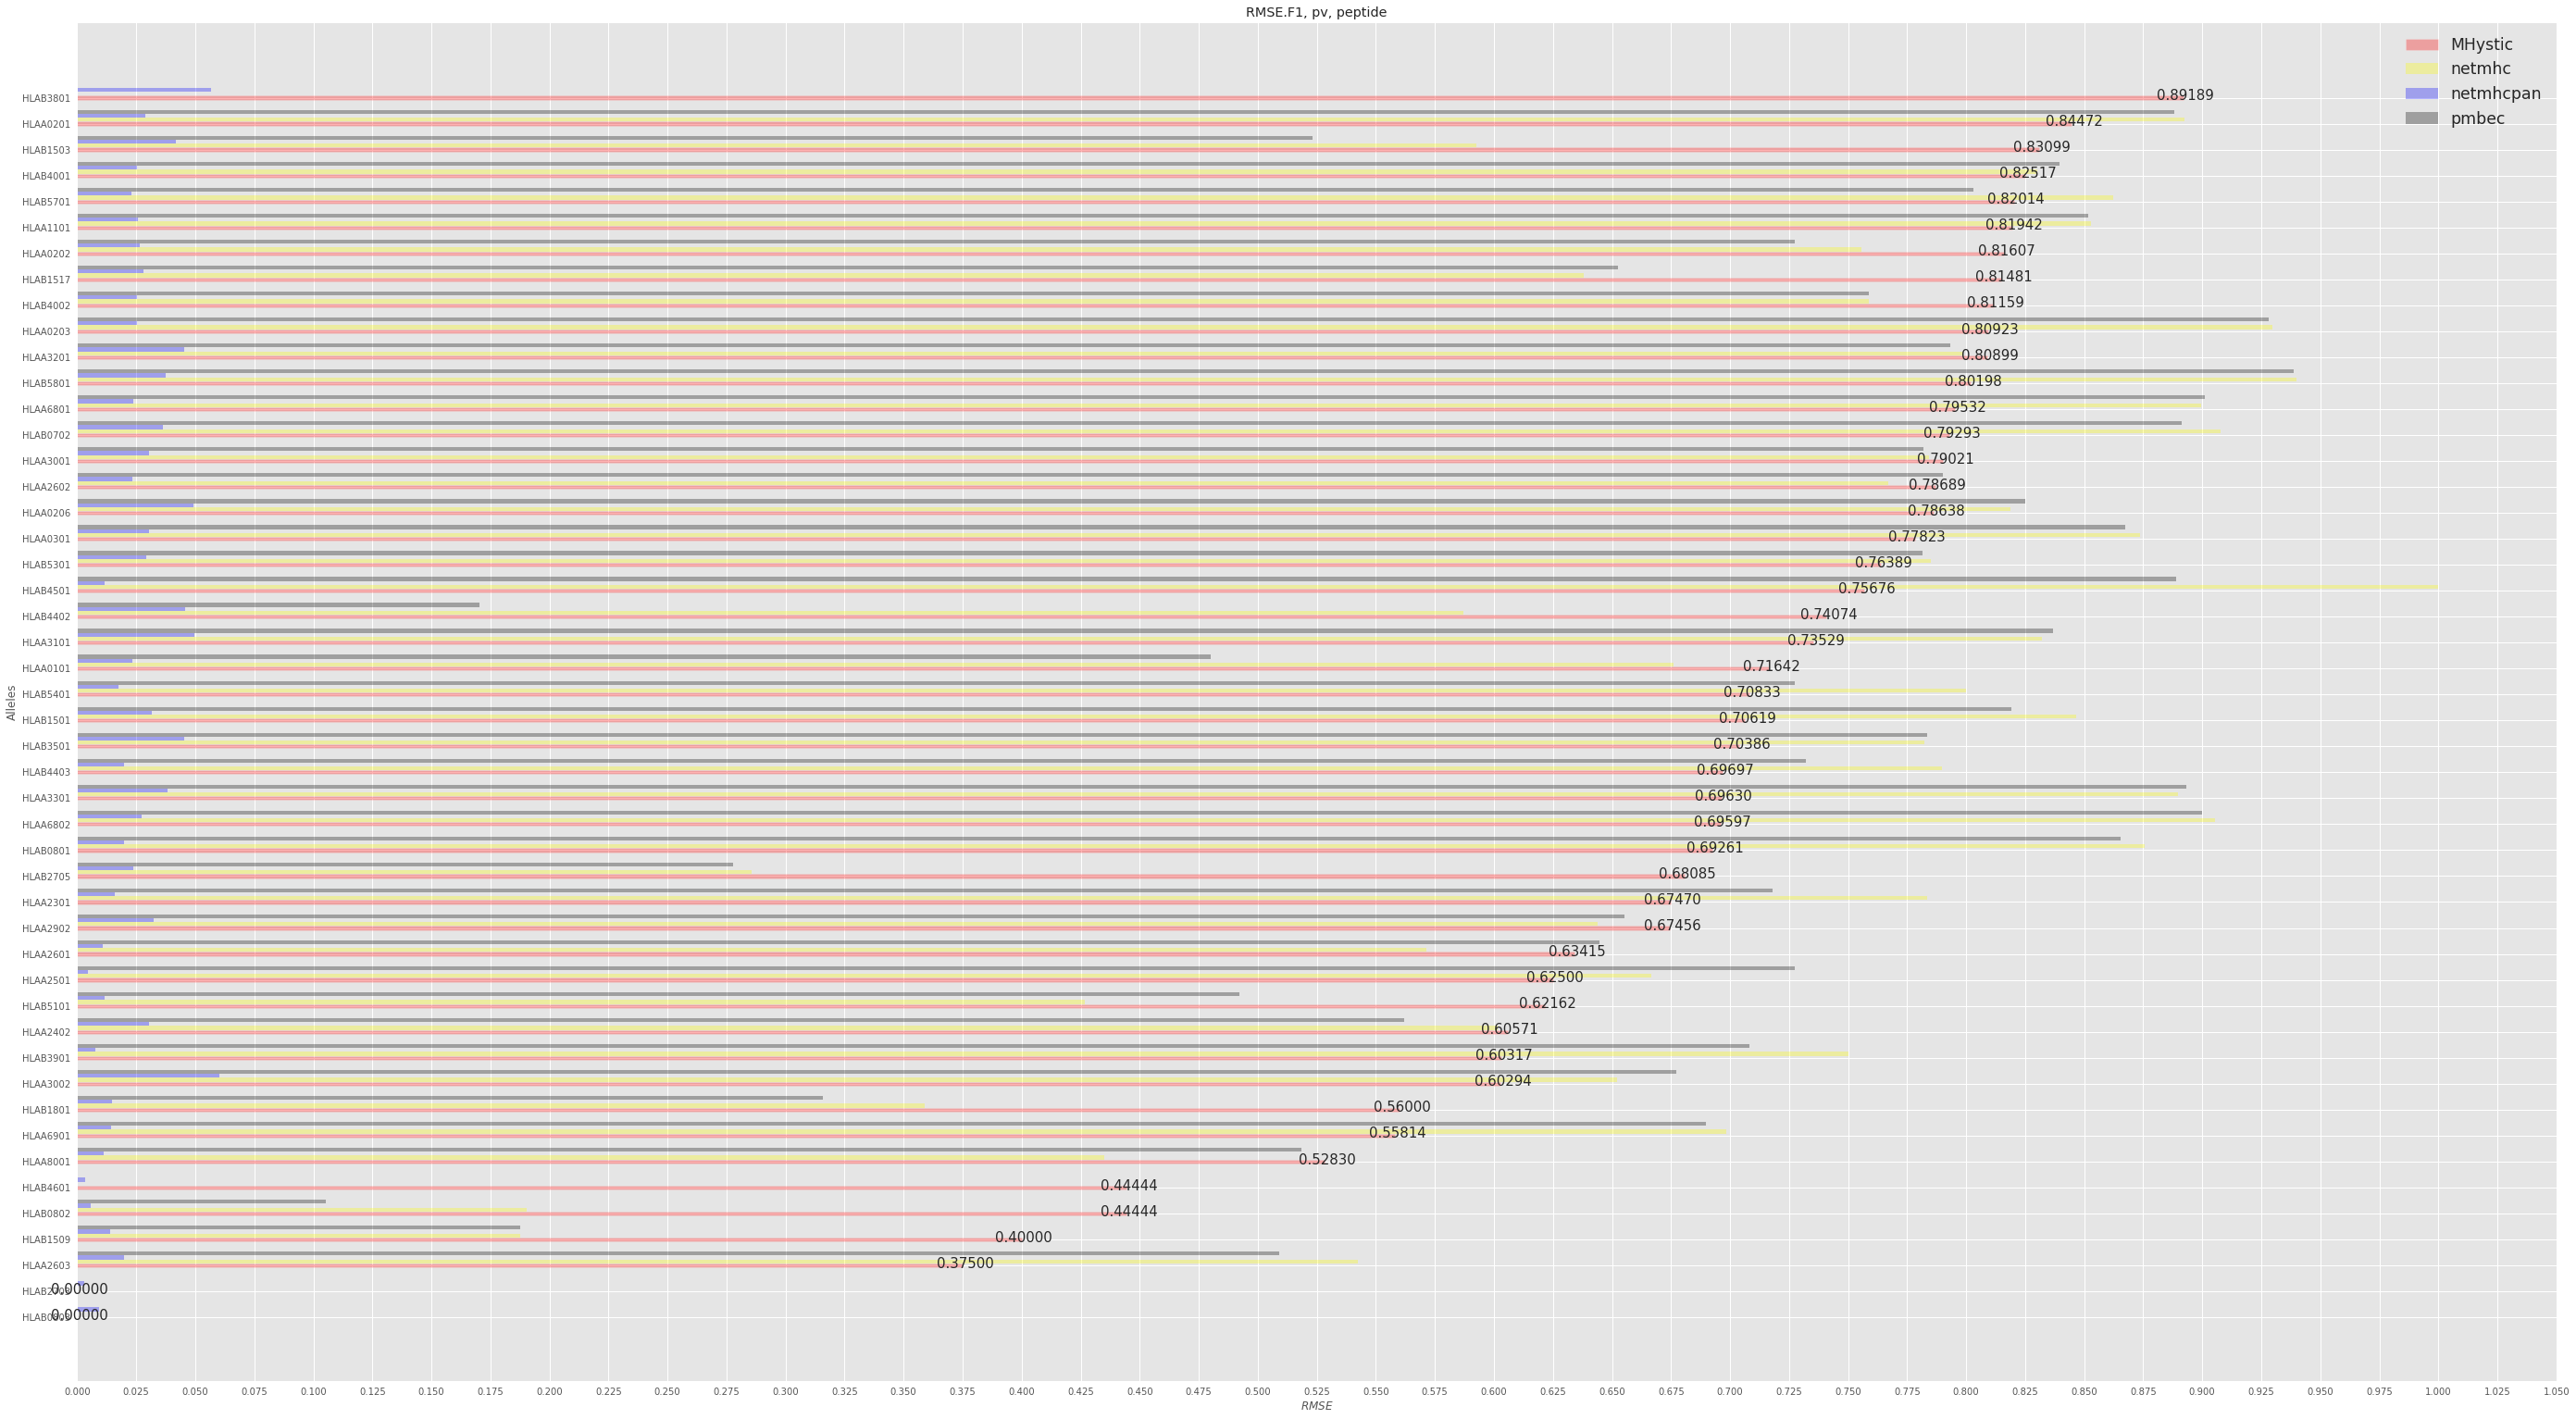

In [12]:
plot_results(performance_df_f1.sort('mhystic', ascending=True), "F1, pv, peptide")

In [19]:
seq2protvec(w2v_proteins, "AVDSDDS")

NameError: name 'np' is not defined

In [18]:
import gensim

model = gensim.models.Word2Vec.load("w2v_models/up9mers_size_10_window_3.pkl")
model.most_similar(["A"], topn=24)

[('R', 0.9981900453567505),
 ('S', 0.9971938133239746),
 ('Q', 0.9941310286521912),
 ('G', 0.9936058521270752),
 ('V', 0.9925956726074219),
 ('W', 0.99196857213974),
 ('T', 0.9916731119155884),
 ('D', 0.9914343357086182),
 ('Y', 0.9876281023025513),
 ('I', 0.986796498298645),
 ('C', 0.9848852157592773),
 ('N', 0.9820692539215088),
 ('P', 0.9815417528152466),
 ('M', 0.9772868752479553),
 ('E', 0.9764869809150696),
 ('H', 0.9754176139831543),
 ('F', 0.9720823764801025),
 ('K', 0.9523937702178955),
 ('L', 0.9323242902755737),
 ('B', 0.6147408485412598),
 ('Z', 0.6059930324554443),
 ('O', 0.39096659421920776),
 ('U', 0.2894287705421448),
 (' ', -0.991263747215271)]